In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib as mpl

mpl.rc('text', usetex = True)
font = {'family' : 'normal',
        'size'   : 20}	
mpl.rc('font', **font)

## Gain function approximations

## Example
Goal: Reproduce Fig 3 in Taghvaei, A., & Mehta, P. G. (2016). Gain Function Approximation in the Feedback Particle Filter.

In [36]:
p = lambda x: 1/2 * (norm.pdf(x,-1,0.4) + norm.pdf(x,1,0.4) )
h = lambda x: x
x_axis = np.linspace(-3,3,1000)

# draw iid samples from p(x) (cheating a bit here)
N = 100
x_PF = np.zeros([N,1])
x_PF[0:int(N/2),:] = np.random.normal(-1,0.4,[int(N/2),1])
x_PF[int(N/2):len(x_PF)] = np.random.normal(1,0.4,[int(N/2),1])

In [37]:
# integrate numerically to get true K (this is quick and dirty and can certainly be optimized!)
K_true = np.zeros(len(x_axis))
for i in np.arange(0,len(x_axis)):
    K_true[i] = - 1/p(x_axis[i]) * integrate.quad(lambda x: h(x)*p(x),-np.inf,x_axis[i])[0]

### Semigroup approximation

In [114]:
def Gain_semigroup(x_PF,h,epsilon=0.1):
    H = h(x_PF)
    h_hat = 1/N * np.sum(H)
    x_PF_M = np.tile(x_PF, (1, N))
    g = np.exp(- (x_PF_M - np.transpose(x_PF_M))**2/(4*epsilon) )
    g_sum_i = np.tile(np.sum(g,0), (N, 1)) 
    k = g * ( np.sqrt(g_sum_i) * np.sqrt(np.transpose( g_sum_i ) ) )**(-1)
    T_ij = k / np.transpose(np.tile(np.sum(k,0),(N,1)))
    
    # solve fixed-point equation
    Phi = np.ones([len(x_PF),2])
    fluctuation = 1
    while fluctuation > 1e-4:
        Phi[:,1] = np.dot(T_ij,Phi[:,0])+(epsilon*(H-h_hat))[:,0]
        Phi[:,1] = Phi[:,1] - 1/N * np.sum(Phi[:,1])
        fluctuation = np.max(np.abs(Phi[:,1]-Phi[:,0]))
        Phi[:,0] = Phi[:,1]
    Phi = Phi[:,1]
    
    # compute gain from Phi (this is where the error is... somewhere)
    K = np.zeros([N,1])
    for i in np.arange(0,N):
        # corrected code: the term that is subtracted from x_PF is not constant in i
        K[i] = 1/(2*epsilon) * np.sum( T_ij[i,:]*Phi* ( x_PF[:,0] - T_ij[i,:].dot(x_PF[:,0])) )
        
    return Phi, K

In [115]:
# compute K with semigroup approximation
Phi, K = Gain_semigroup(x_PF,h)

It seems computing K(x) from $\Phi(x)$ according to Algorithm 1 in T&M 2016 does not work well (bug in code? TBC), so we differentiate $\Phi(x)$ numerically and see what happens.

In [62]:
# Compute gain K from Phi by taking derivative directly (only in 1d)
#order particles (only poss)
arrlinds = x_PF[:,0].argsort()
x_PF_sorted = x_PF[arrlinds]
Phi_sorted = Phi[arrlinds]
K_direct = np.zeros([N,1])
for i in np.arange(1,N-1):
    K_direct[i] = (Phi_sorted[i+1] - Phi_sorted[i-1]) / (x_PF_sorted[i+1]-x_PF_sorted[i-1])
    
# take care of edges (give it same value as neighbors, sorry, this is a cheat)
K_direct[0] = K_direct[1]
K_direct[N-1] = K_direct[N-2]


### ERM Gain estimation (by Simone)

In [53]:
# Directly compute the gain at the sample locations
# input: sample locations
# output: gain function evaluated at the sample locations
def Gain_ERM_direct(samples,h):
    samples = samples[:,0]
    eps=.05
    lamb=10e-3
    # kernel for RKHS and its derivatives
    K = lambda x, y : np.exp(-(x-y)**2/(2*eps))

    Kx = lambda x, y: (y-x)*K(x,y)/eps

    Ky = lambda x, y : (x-y)*K(x,y)/eps

    Kxy = lambda x, y: (eps-(x-y)**2)*K(x,y)/(eps**2)


    
    
    N=len(samples)
    
    # empirical observation function
    zeta=h(samples)
    zeta=zeta-np.average(zeta)
    
    # kernel Gram matrices
    K0mat=K(samples[:,None],samples)
    Kxmat=Kx(samples[:,None],samples)
    Kymat=Ky(samples[:,None],samples)
    Kxymat=Kxy(samples[:,None],samples)
    
    # compute M and b
    M=1/N*np.concatenate((Kymat,Kxymat),axis=0).dot(np.concatenate((Kxmat,Kxymat),axis=1))+lamb*np.concatenate((
                np.concatenate((K0mat,Kxmat),axis=0),
                np.concatenate((Kymat,Kxymat),axis=0)
                 ),axis=1
            )
    b=1/N*np.concatenate((K0mat,Kxmat),axis=0).dot(zeta)
    beta=np.linalg.solve(M,b) # solve equation M.beta=b
    return beta[:N].dot(Kymat)+beta[N:].dot(Kxymat)

In [54]:
K_ERM = Gain_ERM_direct(x_PF,h)

### Plots

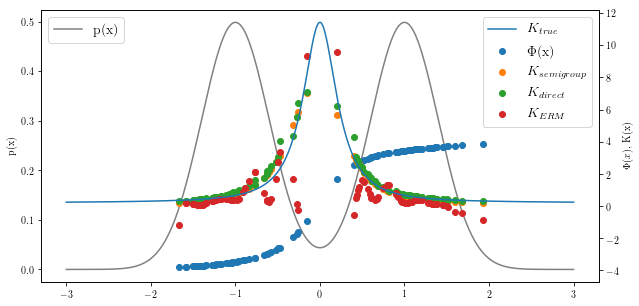

In [116]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x_axis,p(x_axis),color='grey')
ax.set_ylabel('p(x)')
ax.legend([r'p(x)'],loc='upper left',fontsize=14)

ax2 = ax.twinx()
ax2.plot(x_axis,K_true)
ax2.scatter(x_PF,Phi)
ax2.scatter(x_PF,K[:,0])
ax2.scatter(x_PF_sorted,K_direct)
ax2.scatter(x_PF,K_ERM)
ax2.set_ylabel(r'$\Phi(x)$, K(x)')
ax2.legend([r'$K_{true}$',r'$\Phi$(x)',r'$K_{semigroup}$',r'$K_{direct}$',r'$K_{ERM}$'],fontsize=14)
plt.show()